In [ ]:
!pip install arch -q
!pip install yfinance -q

     |████████████████████████████████| 903 kB 11.2 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 


In [ ]:
import datetime as dt
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from datetime import date
from sklearn.model_selection import train_test_split
import matplotlib as mpl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from arch import arch_model
from arch.__future__ import reindexing
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error as mse

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

print(mpl.__version__)  
print(sns.__version__)
%matplotlib inline

3.2.2
0.11.2


In [ ]:
def getScores(test, forecast):
  mse = mean_squared_error(test, forecast)
  print('MSE: '+str(np.round(mse, 2)))

  mae = mean_absolute_error(test, forecast)
  print('MAE: '+str(np.round(mae, 2)))

  rmse = np.sqrt(mean_squared_error(test, forecast))
  print('RMSE: '+str(np.round(rmse, 2)))

  mape = mean_absolute_percentage_error(test, forecast)
  print('MAPE: '+str(np.round(mape, 2)))
  correlation_matrix = np.corrcoef(test, forecast)
  correlation_xy = correlation_matrix[0,1]
  print('Corr: '+str(np.round(correlation_xy, 4)))
  r_squared = correlation_xy**2
  print('R_squared: '+str(np.round(r_squared * 100, 2))+"%")


In [ ]:
def get_volatility(ts, window = None):
  if window:
    ma = ts.rolling(window).mean()
  else:
    ma = ts.expanding().mean()
  output = ((ts - ma)**2)**.5

  return output;

In [ ]:
def get_future_dates(start_date, into_future, offset=1, period="M"):

  start_date = start_date + np.timedelta64(offset, period=period) # "M"  oznacava mesec , 'D' dan ...
  end_date = start_date + np.timedelta64(into_future, period=period) 
  return np.arange(start_date, end_date, dtype=f"datetime64[{period}]") # vraca nove datume koji se kasnije spajaju sa prognoziramin vrednostima

In [ ]:
sp500 = pd.DataFrame(yf.Ticker('^GSPC').history(period="max"))
sp500['date'] = sp500.index
sp500.head()
sp500Month = sp500.Close
sp500Month.index = pd.to_datetime(sp500.index)
sp500Month = sp500Month.resample('1M').mean()

In [ ]:
def predict_dates(num_prediction):
    last_date = sp500Month.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1, freq="M")
    return prediction_dates

**Izračunavanje dnevnih i mesečnih prinosa indeksa S&P 500**

In [ ]:
returns_daily = 100 * sp500.Close.pct_change().dropna()

In [ ]:
returns_monthly = 100 * sp500Month.pct_change().dropna()

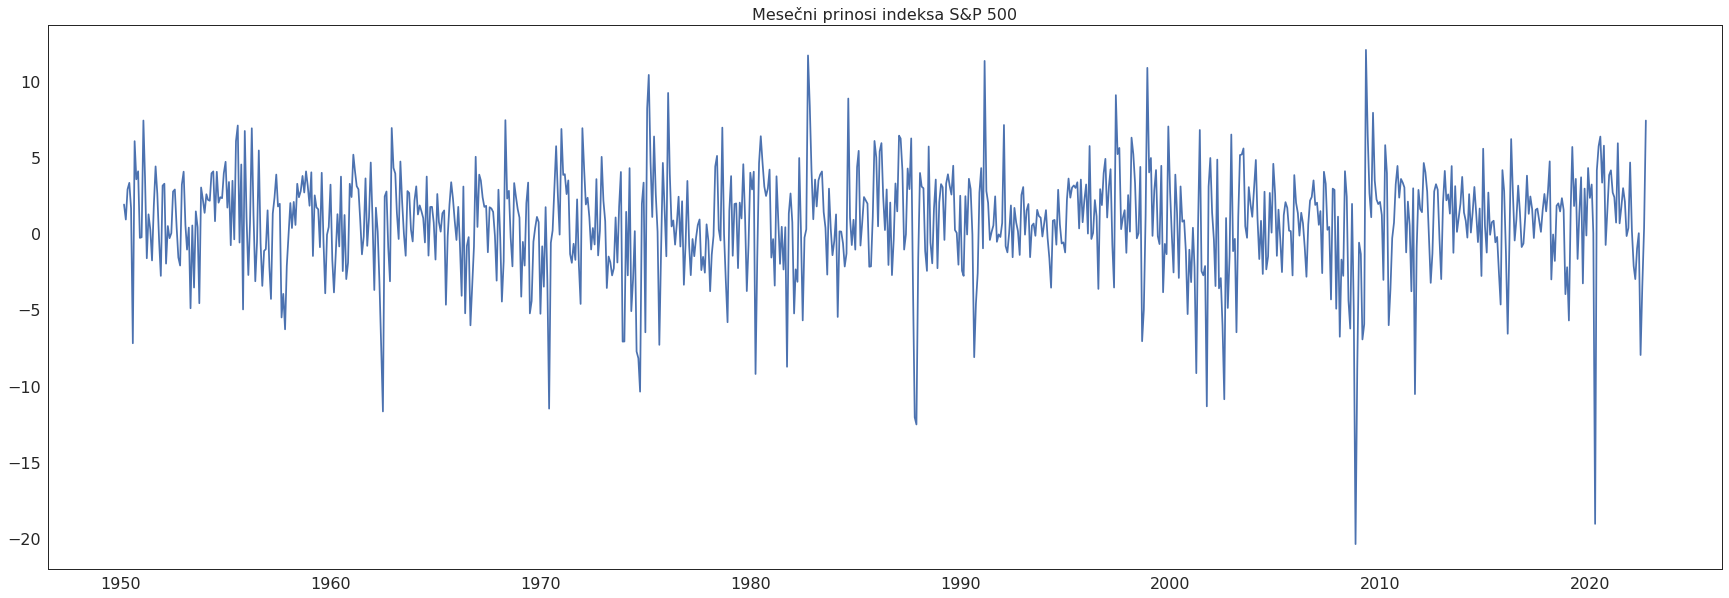

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(30,10))

ax1.plot(returns_monthly)
ax1.set_title("Mesečni prinosi indeksa S&P 500")

fig.show()

In [ ]:
from scipy.stats import skew, pearsonr


In [ ]:
print(skew(returns_monthly))

-0.9000903602717182


**Plotovanje distribuceije prinosa indeksa**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


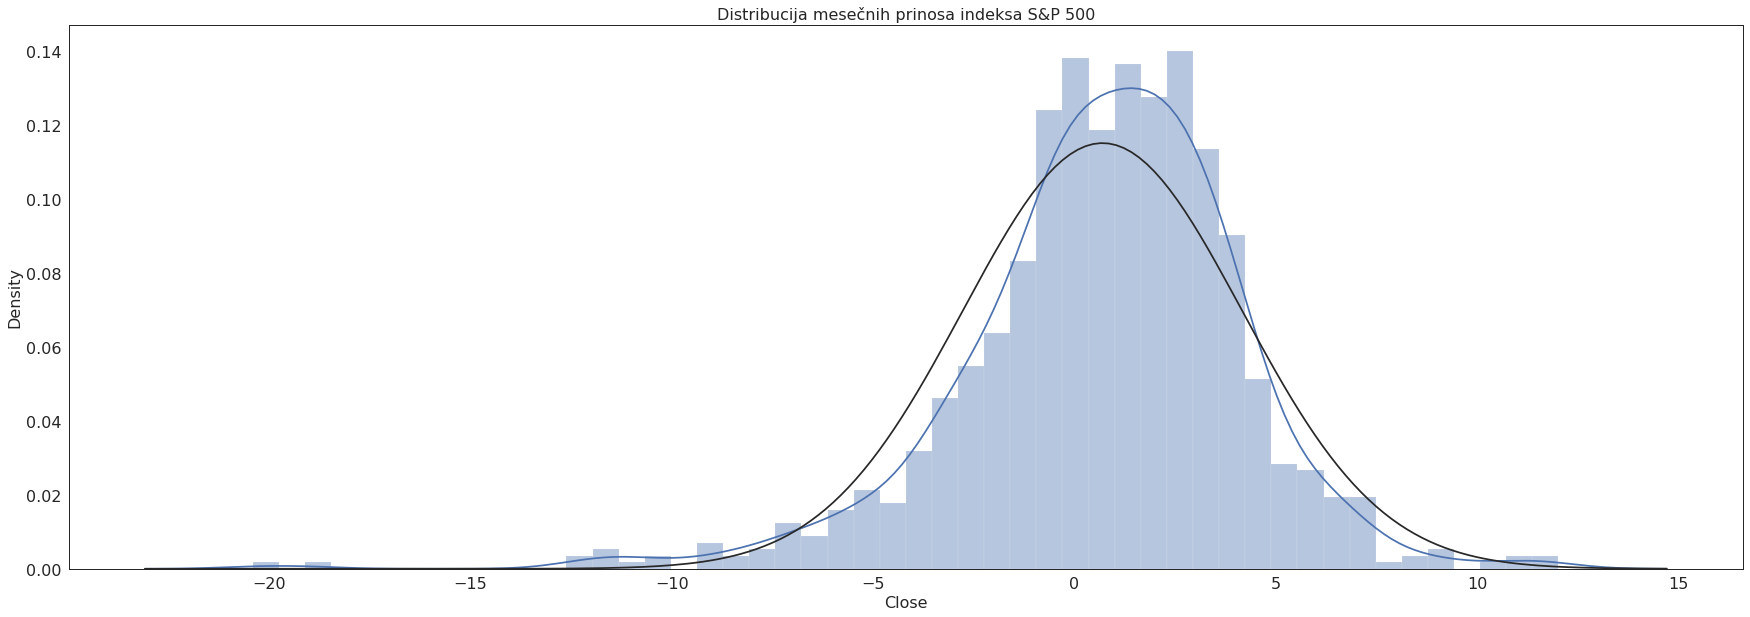

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(30,10))

sns.distplot(returns_monthly, norm_hist=True, fit=stats.norm, bins=50, ax=ax1)
ax1.set_title("Distribucija mesečnih prinosa indeksa S&P 500")

fig.show()

**IZRAČUNAVANJE VOLATILNOSTI**

In [ ]:
volatility_daily = get_volatility(returns_daily)
volatility_monthly = get_volatility(returns_monthly)

In [ ]:
correlation_matrix = np.corrcoef(returns_monthly, volatility_monthly)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

In [ ]:
r_squared, correlation_xy

(0.08713402442732375, -0.2951847293261014)

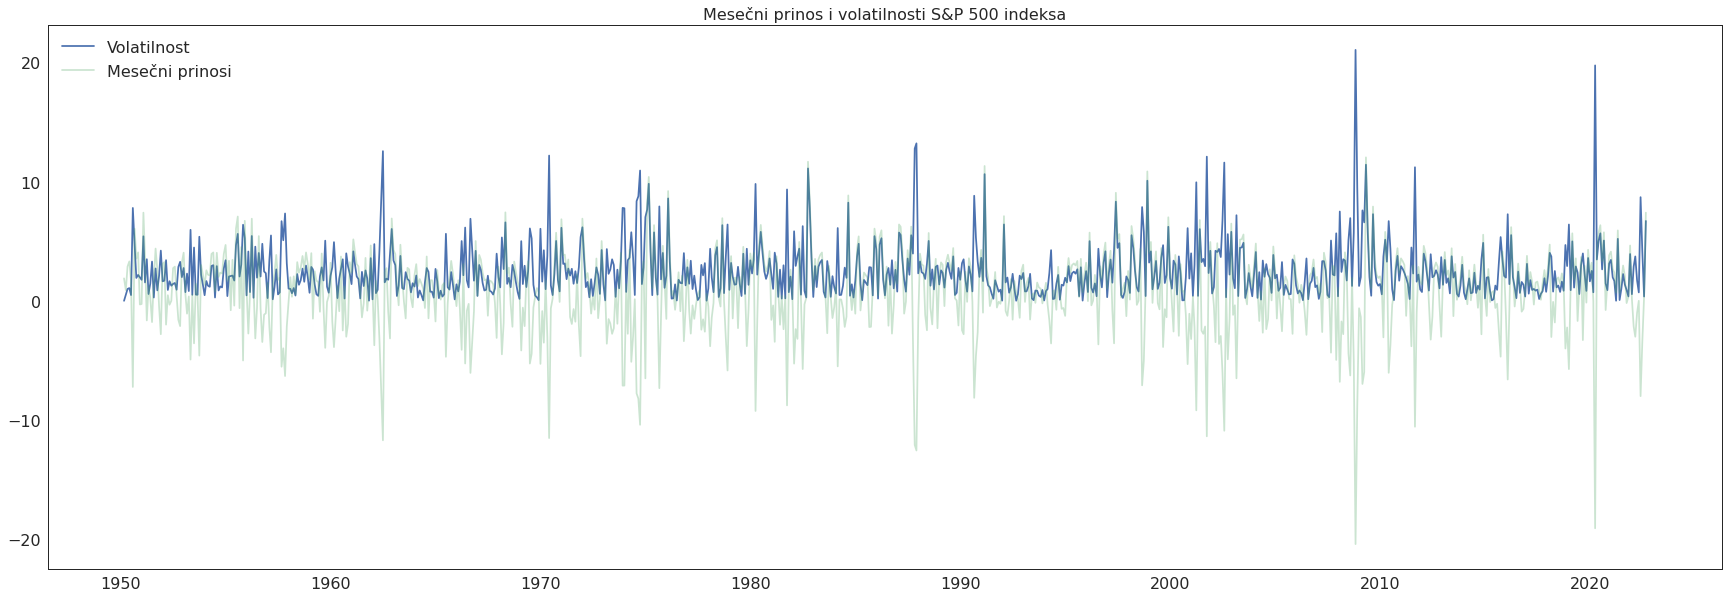

In [ ]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(30,10))

ax1.plot(volatility_monthly, label="Volatilnost")
ax1.plot(returns_monthly, alpha=0.3)
ax1.legend(["Volatilnost", "Mesečni prinosi"])
ax1.set_title("Mesečni prinos i volatilnosti S&P 500 indeksa")

fig.show()

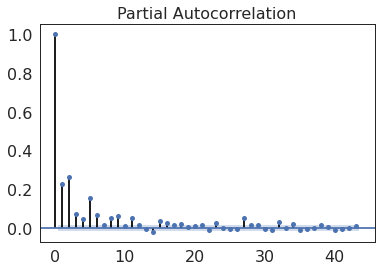

In [ ]:
plot_pacf(returns_daily**2);

In [ ]:
avg_volatility = np.average(volatility_monthly)
avg_vol_list = np.full(len(volatility_monthly), avg_volatility)
avg_vol = pd.DataFrame(avg_vol_list, index=volatility_monthly.index)

Text(0, 0.5, 'St. dev')

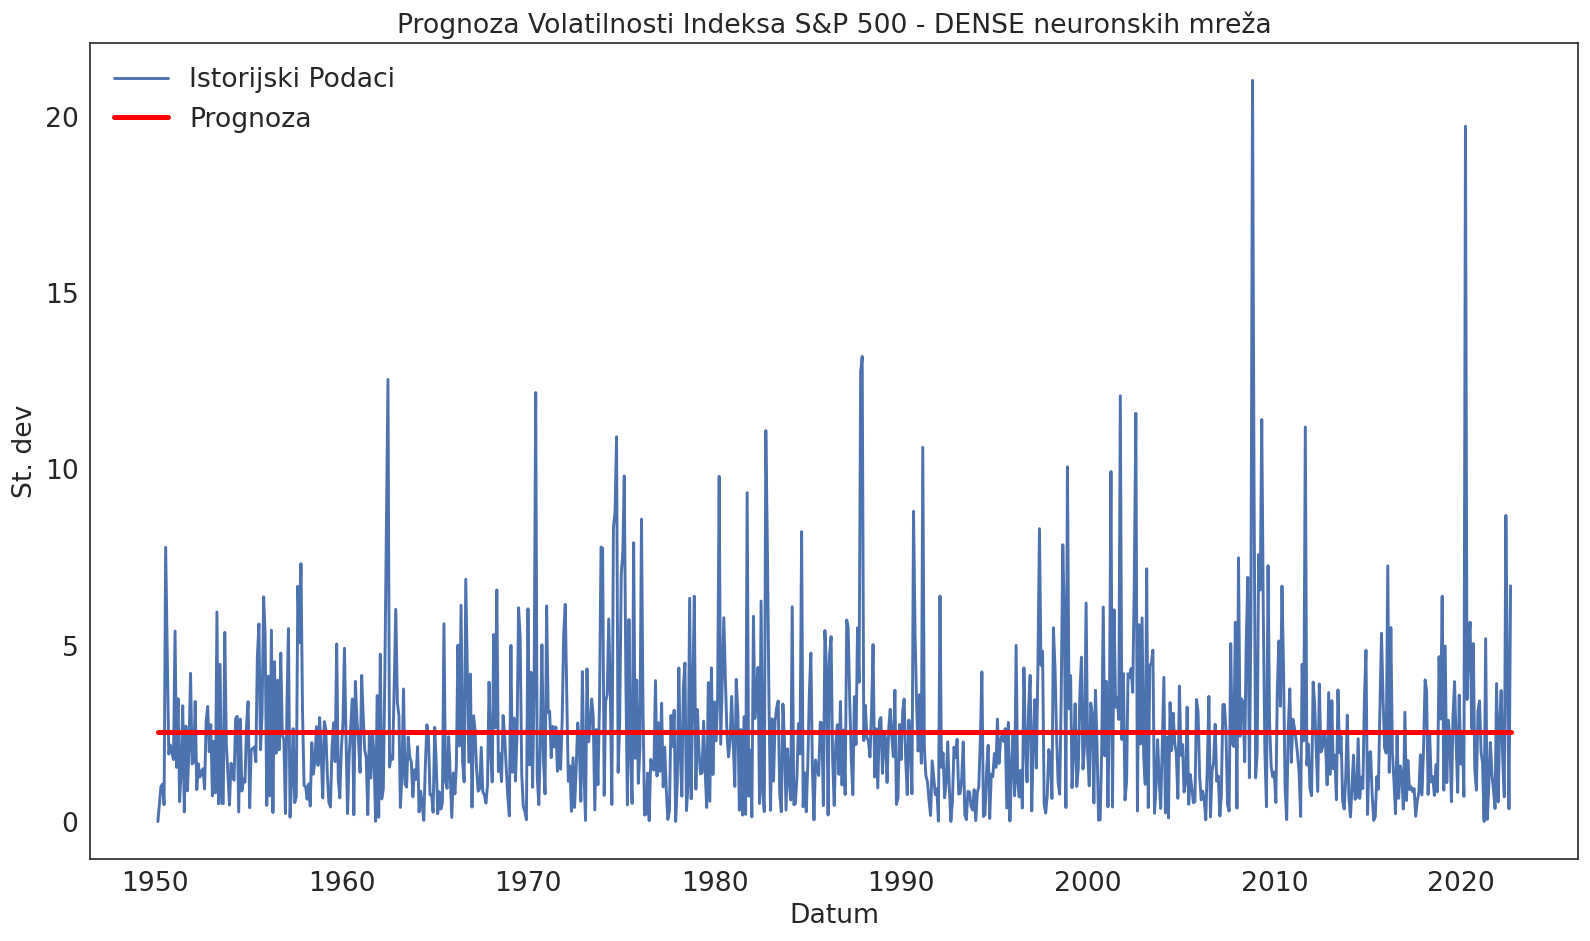

In [ ]:
fig, (ax1)  = plt.subplots(1,1,figsize=(16,9), dpi=120)
plt.subplots_adjust(hspace=0.2)

ax1.plot(volatility_monthly)
ax1.plot(avg_vol,color="red", linewidth=3.0)
ax1.legend(["Istorijski Podaci", "Prognoza"])
ax1.set_title("Prognoza Volatilnosti Indeksa S&P 500 - DENSE neuronskih mreža")
ax1.set_xlabel("Datum")
ax1.set_ylabel("St. dev")


# **GARCH(1,1) Model**

In [ ]:
model = arch_model(returns_monthly, p=1, q=1, vol="GARCH", dist='normal')
model_fit = model.fit(disp='off')

In [ ]:
print(model_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2288.57
Distribution:                  Normal   AIC:                           4585.13
Method:            Maximum Likelihood   BIC:                           4604.21
                                        No. Observations:                  871
Date:                Sun, Aug 21 2022   Df Residuals:                      870
Time:                        09:46:36   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.7987      0.126      6.346  2.203e-10 [  0.552,  1.04

In [ ]:
HORIZONT = 7

In [ ]:
pred_dates = predict_dates(HORIZONT)[1:]
pred_dates

DatetimeIndex(['2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28', '2023-03-31'],
              dtype='datetime64[ns]', freq='M')

2022-09-30    4.224596
2022-10-31    4.172912
2022-11-30    4.124987
2022-12-31    4.080580
2023-01-31    4.039462
2023-02-28    4.001415
2023-03-31    3.966233
Freq: M, dtype: float64


Text(0.5, 1.0, 'Prognoza volatilnosti')

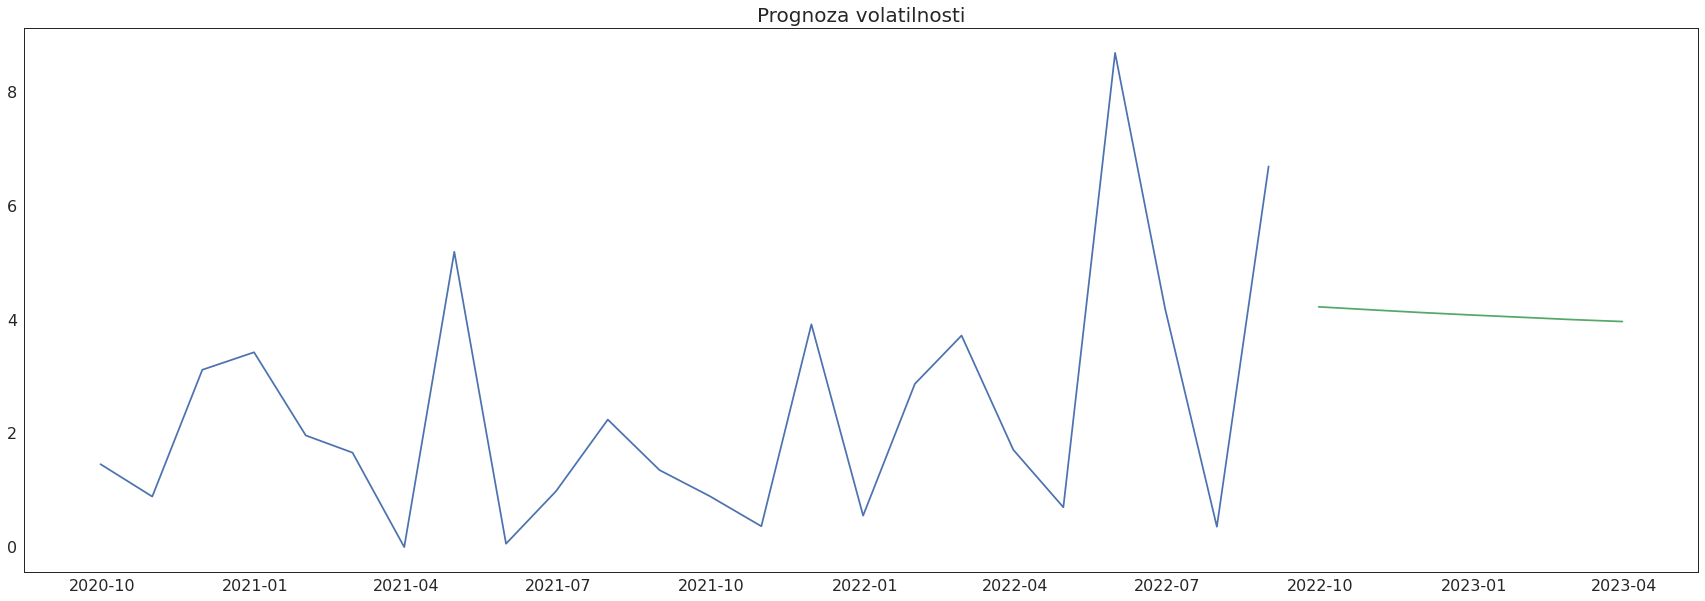

In [ ]:
train = returns_monthly

model = arch_model(train, p=1, q=1, vol="GARCH", dist="skewt")
model_fit = model.fit(disp='off')
pred = model_fit.forecast(horizon=7)
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=pred_dates)

print(pred)
plt.figure(figsize=(30,10))
plt.plot(volatility_monthly[-24:])
plt.plot(pred)
plt.title('Prognoza volatilnosti', fontsize=20)

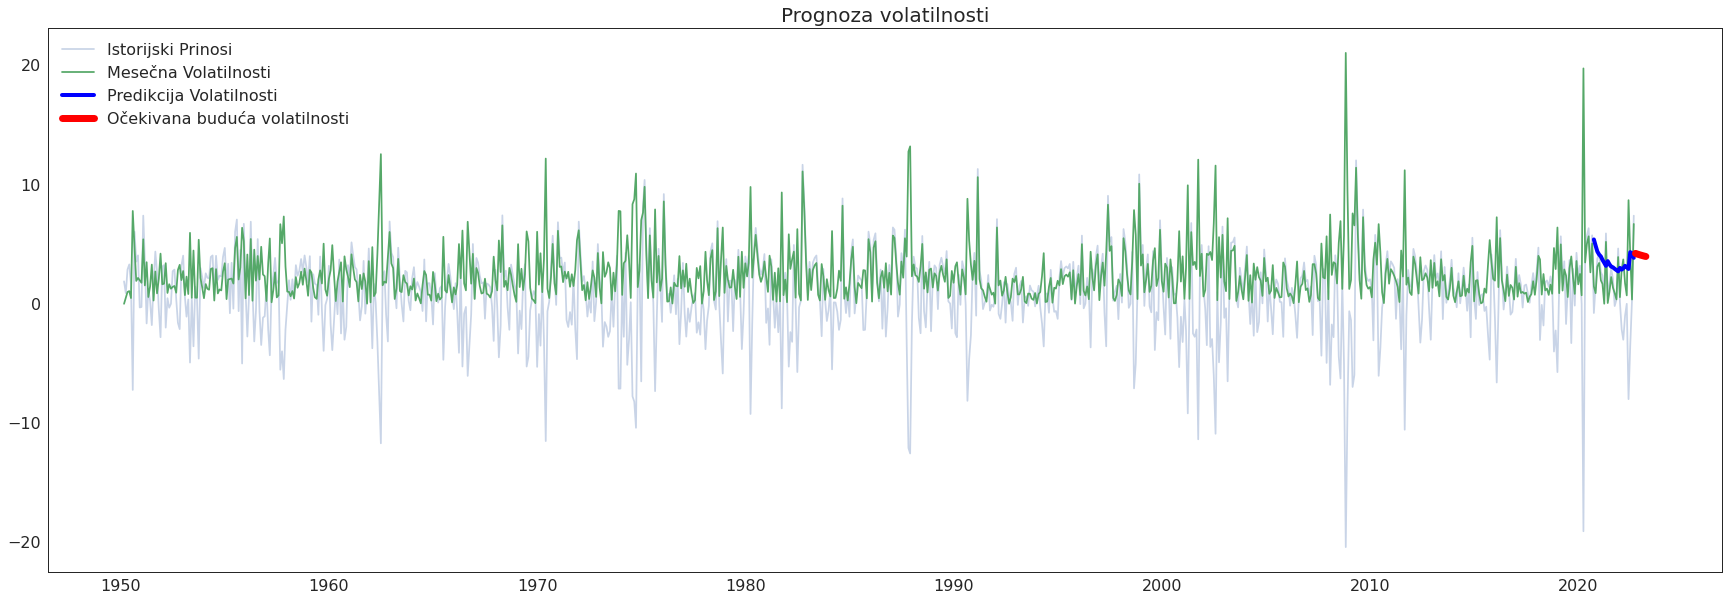

In [ ]:
rolling_predictions = []
test_size = 12*2
# prognoza uz pomog pokretnih okvira (rolling window)
for i in range(test_size):
    train = returns_monthly[:-(test_size-i)]
    model = arch_model(train, p=1, q=1, vol="GARCH")
    model_fit = model.fit(disp='off')
    pred_fit = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred_fit.variance.values[-1,:][0]))

# plotovanje grafika
rolling_predictions = pd.Series(rolling_predictions, index=returns_monthly.index[-12*2:])


plt.figure(figsize=(30,10))

true, = plt.plot(returns_monthly, alpha=0.3)
vol_m, = plt.plot(volatility_monthly)
preds, = plt.plot(rolling_predictions,  c='b', label='y1',linewidth=4.0)
hh, = plt.plot(pred,  c='r',linewidth=7.0)

plt.title('Prognoza volatilnosti', fontsize=20)
plt.legend(['Istorijski Prinosi', 'Mesečna Volatilnosti' ,'Predikcija Volatilnosti', "Očekivana buduća volatilnosti"], fontsize=16)

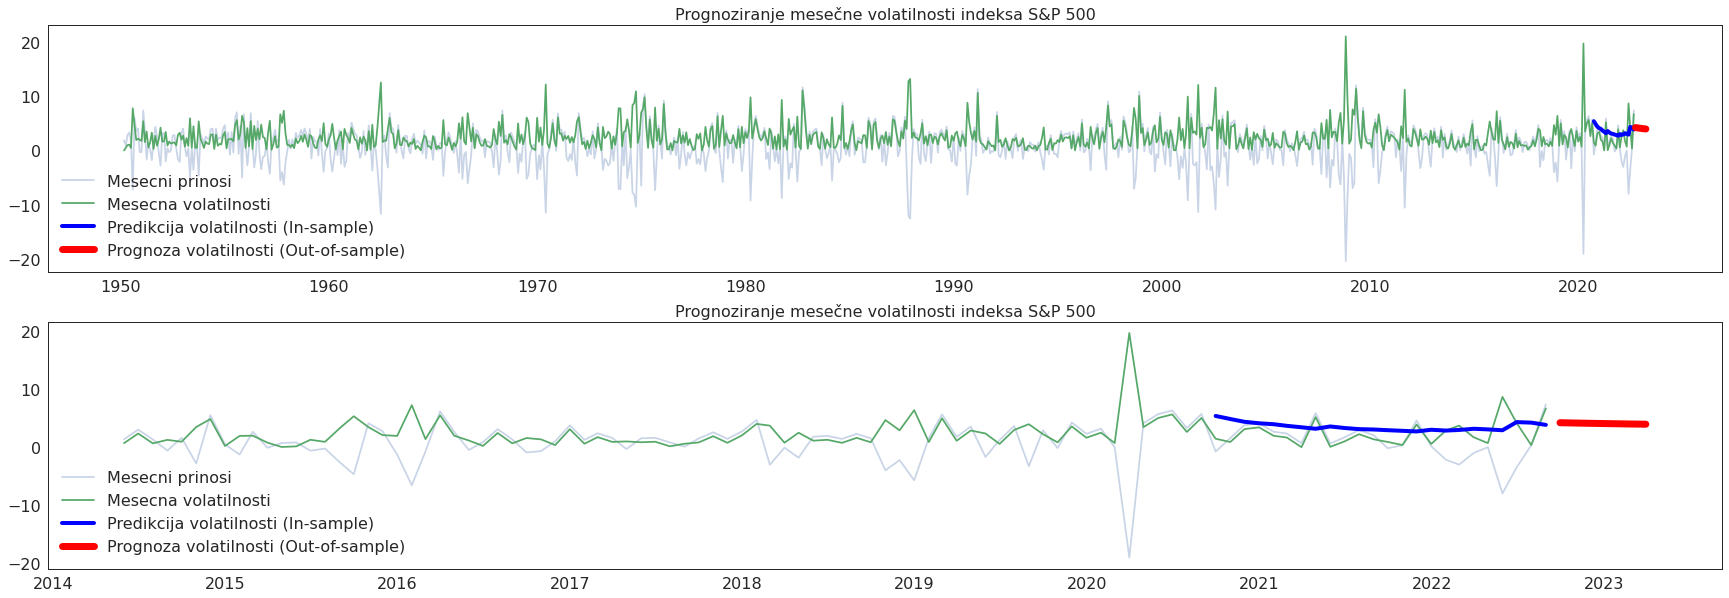

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(30,10))

ax1.plot(returns_monthly, alpha=0.3)
ax1.plot(volatility_monthly)
ax1.plot(rolling_predictions,  c='b', label='y1',linewidth=4.0)
ax1.plot(pred,  c='r',linewidth=7.0)

ax1.legend(["Mesecni prinosi", "Mesecna volatilnosti", 'Predikcija volatilnosti (In-sample)', "Prognoza volatilnosti (Out-of-sample)"], loc="lower left")

ax1.set_title("Prognoziranje mesečne volatilnosti indeksa S&P 500")

ax2.plot(returns_monthly[-100:], alpha=0.3)
ax2.plot(volatility_monthly[-100:])
ax2.plot(rolling_predictions[-100:],  c='b', label='y1',linewidth=4.0)
ax2.plot(pred[-100:],  c='r',linewidth=7.0)
ax2.legend(["Mesecni prinosi", "Mesecna volatilnosti", 'Predikcija volatilnosti (In-sample)', "Prognoza volatilnosti (Out-of-sample)"], loc="lower left")
ax2.set_title("Prognoziranje mesečne volatilnosti indeksa S&P 500")

fig.show()

In [ ]:
getScores(volatility_monthly[-len(rolling_predictions):], rolling_predictions)

MSE: 6.71
MAE: 2.21
RMSE: 2.59
MAPE: 43.72
Corr: -0.0907
R_squared: 0.82%


In [ ]:
train, test = train_test_split(returns_monthly, train_size=0.9, shuffle=False)

Pronalazak Optimalnog GARCH modela optimizacijom AIC kriterijuma

In [ ]:
aic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(train, mean='zero',vol='GARCH', p=p, o=0, q=q) .fit(disp='off')
        aic_garch.append(garch.aic)
        if garch.aic == np.min(aic_garch):
            best_param = p, q


garch = arch_model(train, mean='zero', vol='GARCH', p=1, q=1).fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=train.iloc[-1:].index, horizon=len(test))
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2071.02
Distribution:                  Normal   AIC:                           4148.04
Method:            Maximum Likelihood   BIC:                           4162.03
                                        No. Observations:                  783
Date:                Sun, Aug 21 2022   Df Residuals:                      783
Time:                        10:28:56   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.0386      0.370      2.805  5.032e-03   [  0.31

In [ ]:
forecast_values = np.sqrt(forecast_garch.variance.values[-1, :])

Text(0, 0.5, 'St. dev')

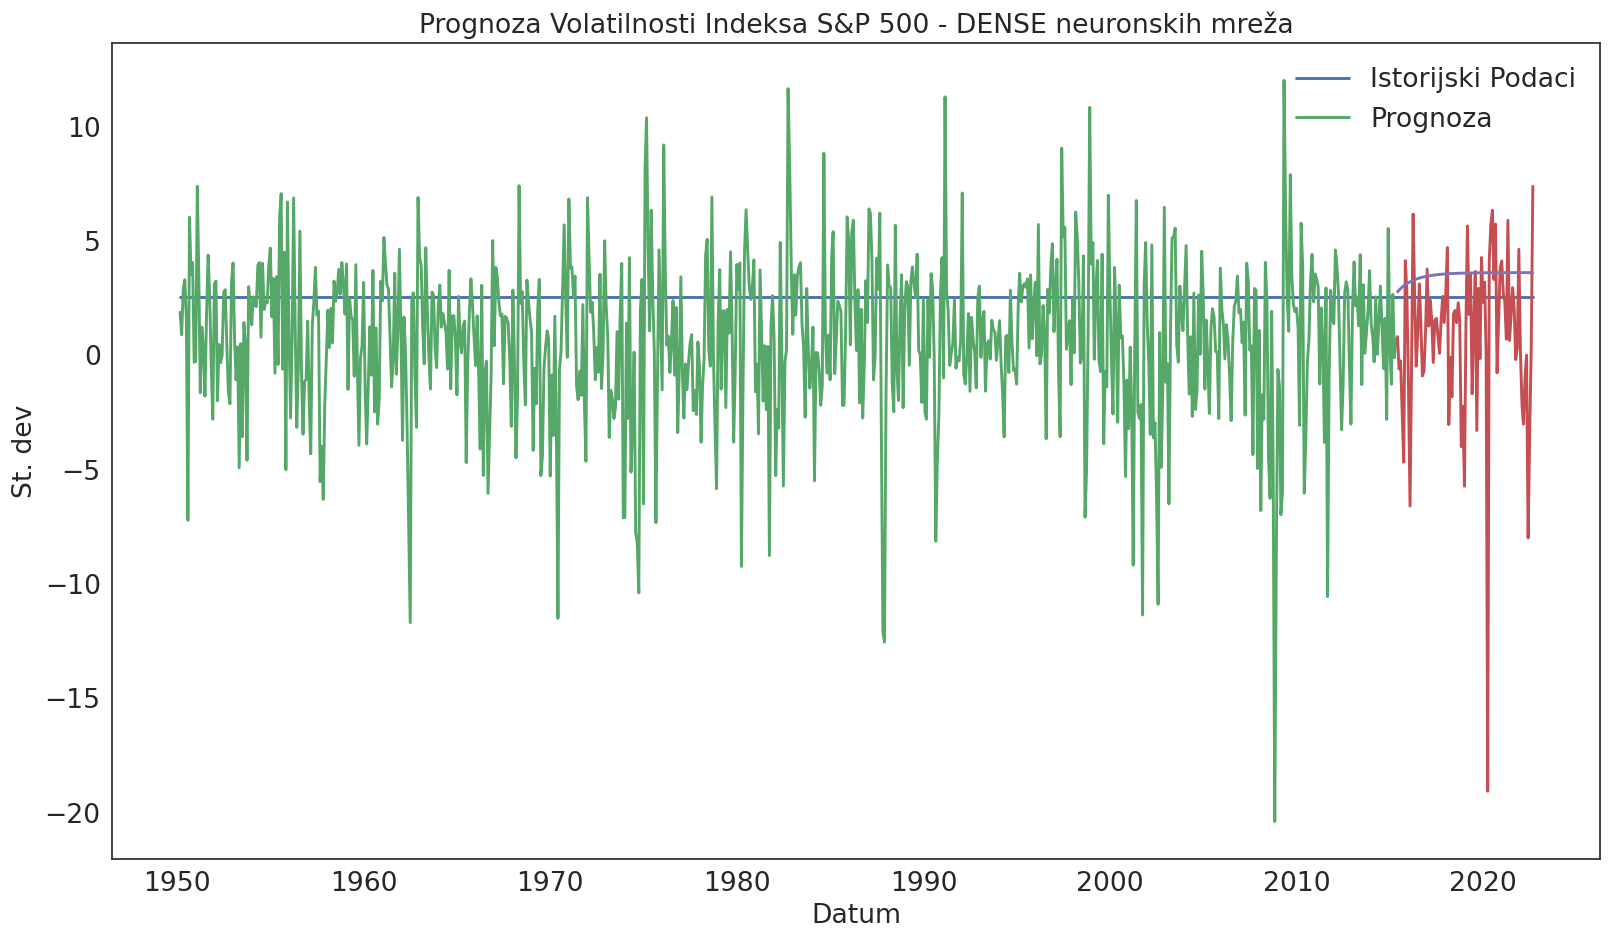

In [ ]:
fig, (ax1)  = plt.subplots(1,1,figsize=(16,9), dpi=120)
plt.subplots_adjust(hspace=0.2)

ax1.plot(avg_vol[-1000:], label="Trening")
ax1.plot(train[-1000:], label="Trening")
ax1.plot(test, label="Trening")
ax1.plot(test.index, forecast_values, label="Predikcija")

ax1.legend(["Istorijski Podaci", "Prognoza"])
ax1.set_title("Prognoza Volatilnosti Indeksa S&P 500 - DENSE neuronskih mreža")
ax1.set_xlabel("Datum")
ax1.set_ylabel("St. dev")


**ROLLING PROGNOZA**

In [ ]:
rolling_predictions = []
test_size = len(test)

# prognoza uz pomog pokretnih okvira (rolling window)
for i in range(test_size):
    train = returns_monthly[:-(test_size-i)]
    model = arch_model(train, p=1, q=1, vol="GARCH")
    model_fit = model.fit(disp='off')
    pred_fit = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred_fit.variance.values[-1,:][0]))

# plotovanje grafika
rolling_predictions = pd.Series(rolling_predictions, index=returns_monthly.index[-len(test):])

Text(0, 0.5, 'St. dev')

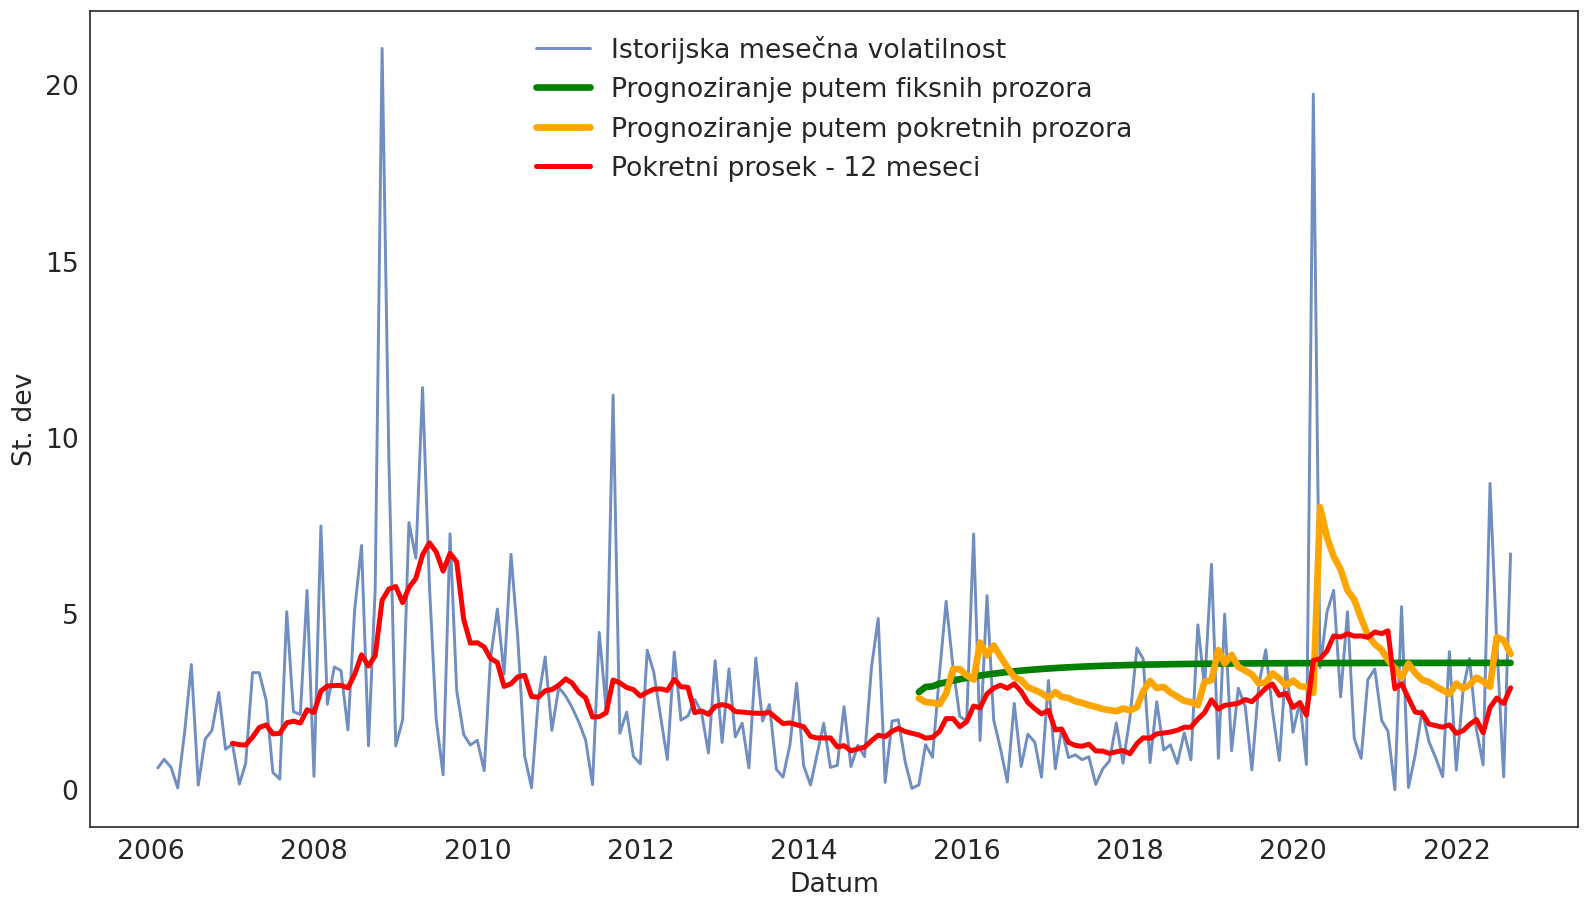

In [ ]:
fig, (ax1)  = plt.subplots(1,1,figsize=(16,9), dpi=120)
plt.subplots_adjust(hspace=0.2)

rolling_vol_yearly = volatility_monthly[-200:].rolling(12).mean()

ax1.plot(volatility_monthly[-200:], alpha=0.8 )
ax1.plot(test.index, forecast_values, color='green', linewidth=4.0)
ax1.plot(rolling_predictions, color='orange', linewidth=4.0)
ax1.plot(rolling_vol_yearly,color='red', linewidth=3.0)
# ax1.plot(avg_vol[-200:],color='black', linewidth=1.0)

ax1.legend(["Istorijska mesečna volatilnost", "Prognoziranje putem fiksnih prozora", "Prognoziranje putem pokretnih prozora", "Pokretni prosek - 12 meseci", "Prosečna istorijska volatilnosti"])
ax1.set_xlabel("Datum")
ax1.set_ylabel("St. dev")

**PERFORMANSE FIKSNIH PROZORA**

In [ ]:
getScores(volatility_monthly[-len(forecast_values):], forecast_values)

MSE: 7.76
MAE: 2.1
RMSE: 2.78
MAPE: 14.23
Corr: 0.0683
R_squared: 0.47%


Performanse u odnosu na pokretni prosek

In [ ]:
getScores(rolling_vol_yearly[-len(test):], forecast_values)

MSE: 2.11
MAE: 1.32
RMSE: 1.45
MAPE: 0.75
Corr: 0.2477
R_squared: 6.13%


**PERFORMANSE POKRETNIH PROZORA**

In [ ]:
getScores(volatility_monthly[-len(rolling_predictions):], rolling_predictions)

MSE: 7.77
MAE: 1.99
RMSE: 2.79
MAPE: 13.35
Corr: 0.1432
R_squared: 2.05%


In [ ]:
getScores(rolling_vol_yearly[-len(test):], rolling_predictions)

MSE: 1.43
MAE: 1.03
RMSE: 1.19
MAPE: 0.52
Corr: 0.7591
R_squared: 57.62%


**BUDUCA VOLATILNOSTI OUT OF SAMPLE**

In [ ]:
garch = arch_model(returns_monthly, mean='zero', vol='GARCH', p=1, o=0, q=1).fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=train.iloc[-1:].index, horizon=12)
forecast_garch = forecast
forecast_values = np.sqrt(forecast_garch.variance.values[-1, :])

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2313.55
Distribution:                  Normal   AIC:                           4633.10
Method:            Maximum Likelihood   BIC:                           4647.41
                                        No. Observations:                  871
Date:                Sun, Aug 21 2022   Df Residuals:                      871
Time:                        09:51:01   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.2552      0.406      3.089  2.009e-03   [  0.45

In [ ]:
sp500.index[-1]

Timestamp('2022-08-19 00:00:00')

In [ ]:
dates_forecast = get_future_dates(sp500.index[-1], 12, period="M")
future_forecast = pd.DataFrame(forecast_values, index=dates_forecast)
future_forecast

NameError: ignored

In [ ]:
dates_forecast

array(['2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02',
       '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08'],
      dtype='datetime64[M]')

Text(0, 0.5, 'St. dev')

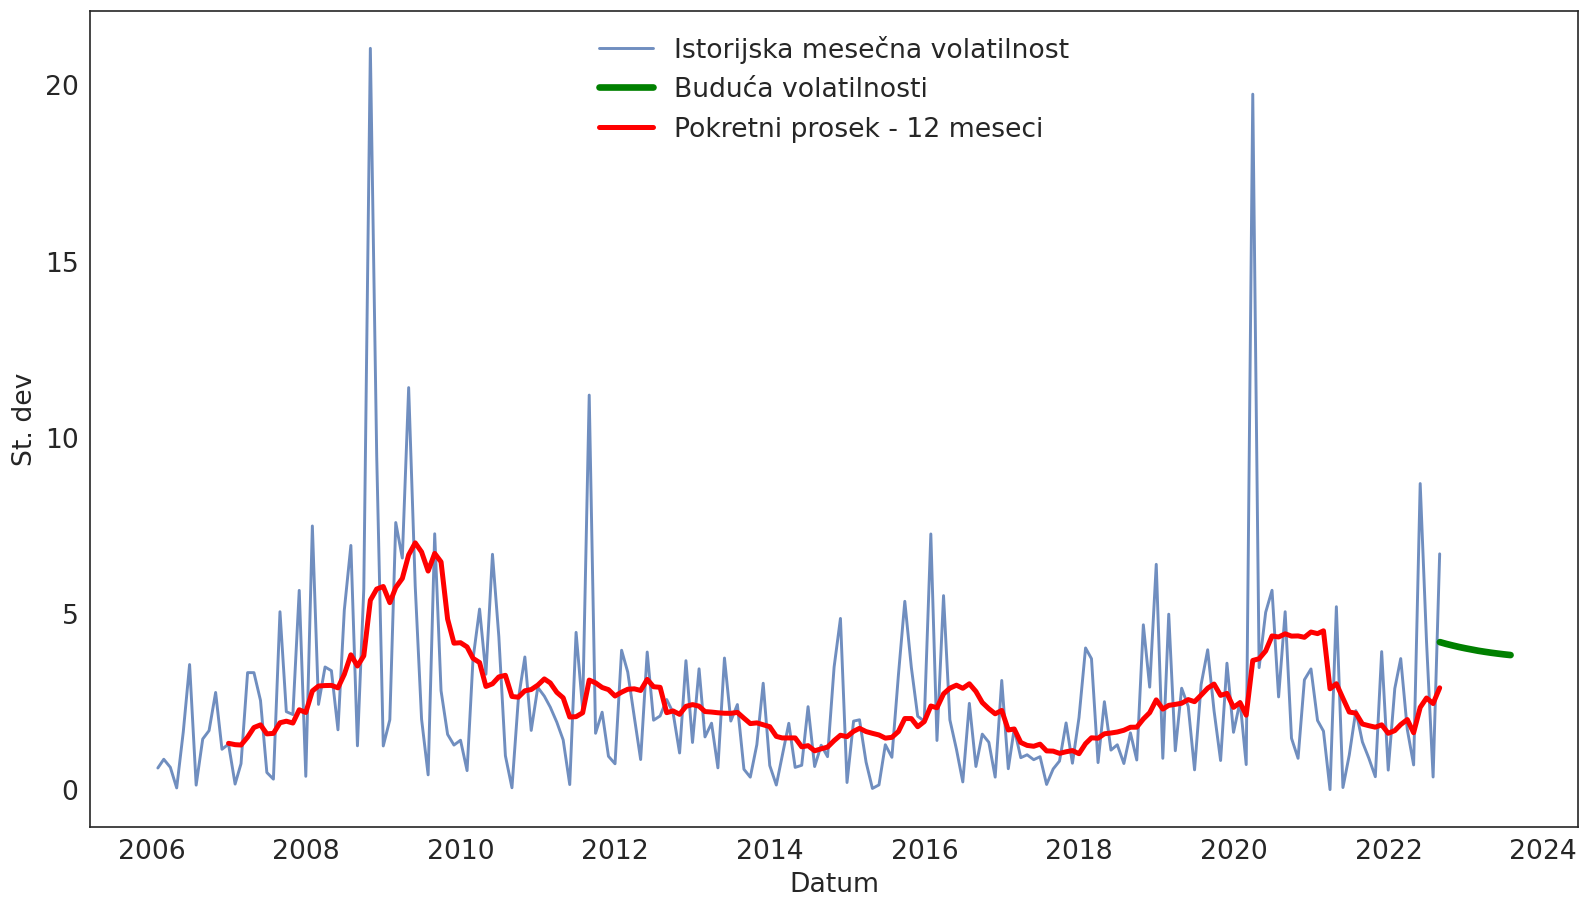

In [ ]:
fig, (ax1)  = plt.subplots(1,1,figsize=(16,9), dpi=120)
plt.subplots_adjust(hspace=0.2)

rolling_vol_yearly = volatility_monthly[-200:].rolling(12).mean()

ax1.plot(volatility_monthly[-200:], alpha=0.8 )
ax1.plot(future_forecast,color='green', linewidth=4.0)


# ax1.plot(rolling_predictions, color='orange', linewidth=4.0)
ax1.plot(rolling_vol_yearly,color='red', linewidth=3.0)

ax1.legend(["Istorijska mesečna volatilnost", "Buduća volatilnosti", "Pokretni prosek - 12 meseci"])
ax1.set_xlabel("Datum")
ax1.set_ylabel("St. dev")

In [ ]:
future_forecast

,0
2022-09-01,4.187474
2022-10-01,4.136962
2022-11-01,4.090739
2022-12-01,4.048480
2023-01-01,4.009875
2023-02-01,3.974636
2023-03-01,3.942494
2023-04-01,3.913195
2023-05-01,3.886507
2023-06-01,3.862209


**NEURONSKE MREZE**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf

from keras.models import Sequential
from keras.layers import LSTM, Dense, LeakyReLU, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers


import statsmodels
from math import sqrt
import numpy as np
from numpy import mean
from numpy import median
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import  Holt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib as mpl

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

print(mpl.__version__)  
print(sns.__version__)
%matplotlib inline

3.2.2
0.11.2


In [ ]:
WINDOW_SIZE=7

In [ ]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Vraca vrednosti prognoze kao decimalne brojeve
  """
  # Prazna lista koja ce cuvati vrednosti prognoze
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # samo predikcije poslednjeg okvira 

  # Pravi INTO_FUTURE broj prognoza
  for _ in range(into_future):
    
    # pravljenj prognoza osnovu vrednosti koje su vec prognozirane
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Okvir: \n {last_window} -> Predkcija: {tf.squeeze(future_pred).numpy()}\n")
    
    # dodavanje predikcija na postojecu varijablu future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Azuriranje poslednjeg okvira novim predikcijama, samo okvir WINDOW_SIZE je koriscen za predikciju
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [ ]:
# Hiperparametri 
HORIZON = 1
WINDOW_SIZE = 5

# pravljenje duplikata 
complete_data = pd.DataFrame(volatility_monthly).copy()

# Kreiranje okvira sa novim kolonama
for i in range(WINDOW_SIZE): # pomeranje vrednosti za svaki WINDOW_SIZE
  complete_data[f"Volatility+{i+1}"] = complete_data["Close"].shift(periods=i+1)

In [ ]:
train, test = train_test_split(complete_data, test_size=0.1, shuffle=False)

In [ ]:
# Procesiranje podataka za nadgledano ucenje
# y_all -> labele
# X_all -> obelezija
X_test = test.drop(["Close"], axis=1).dropna().to_numpy() 
y_test = test.dropna()["Close"].to_numpy()

features_dataset_test = tf.data.Dataset.from_tensor_slices(X_test)
labels_dataset_test = tf.data.Dataset.from_tensor_slices(y_test)

dataset_test = tf.data.Dataset.zip((features_dataset_test, labels_dataset_test))

BATCH_SIZE = 1024 
dataset_test = dataset_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_test

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
X_all = train.drop(["Close"], axis=1).dropna().to_numpy() 
y_all = train.dropna()["Close"].to_numpy()

In [ ]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

BATCH_SIZE = 1024 
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)

# Kreiranje modela
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Kompajliranje
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# treniranje modela koji ce previti prognoze
model_9.fit(dataset_all,
            epochs=1000,
            verbose=0,validation_data=(X_test, y_test)) 

Text(0, 0.5, 'Gubitak (loss)')

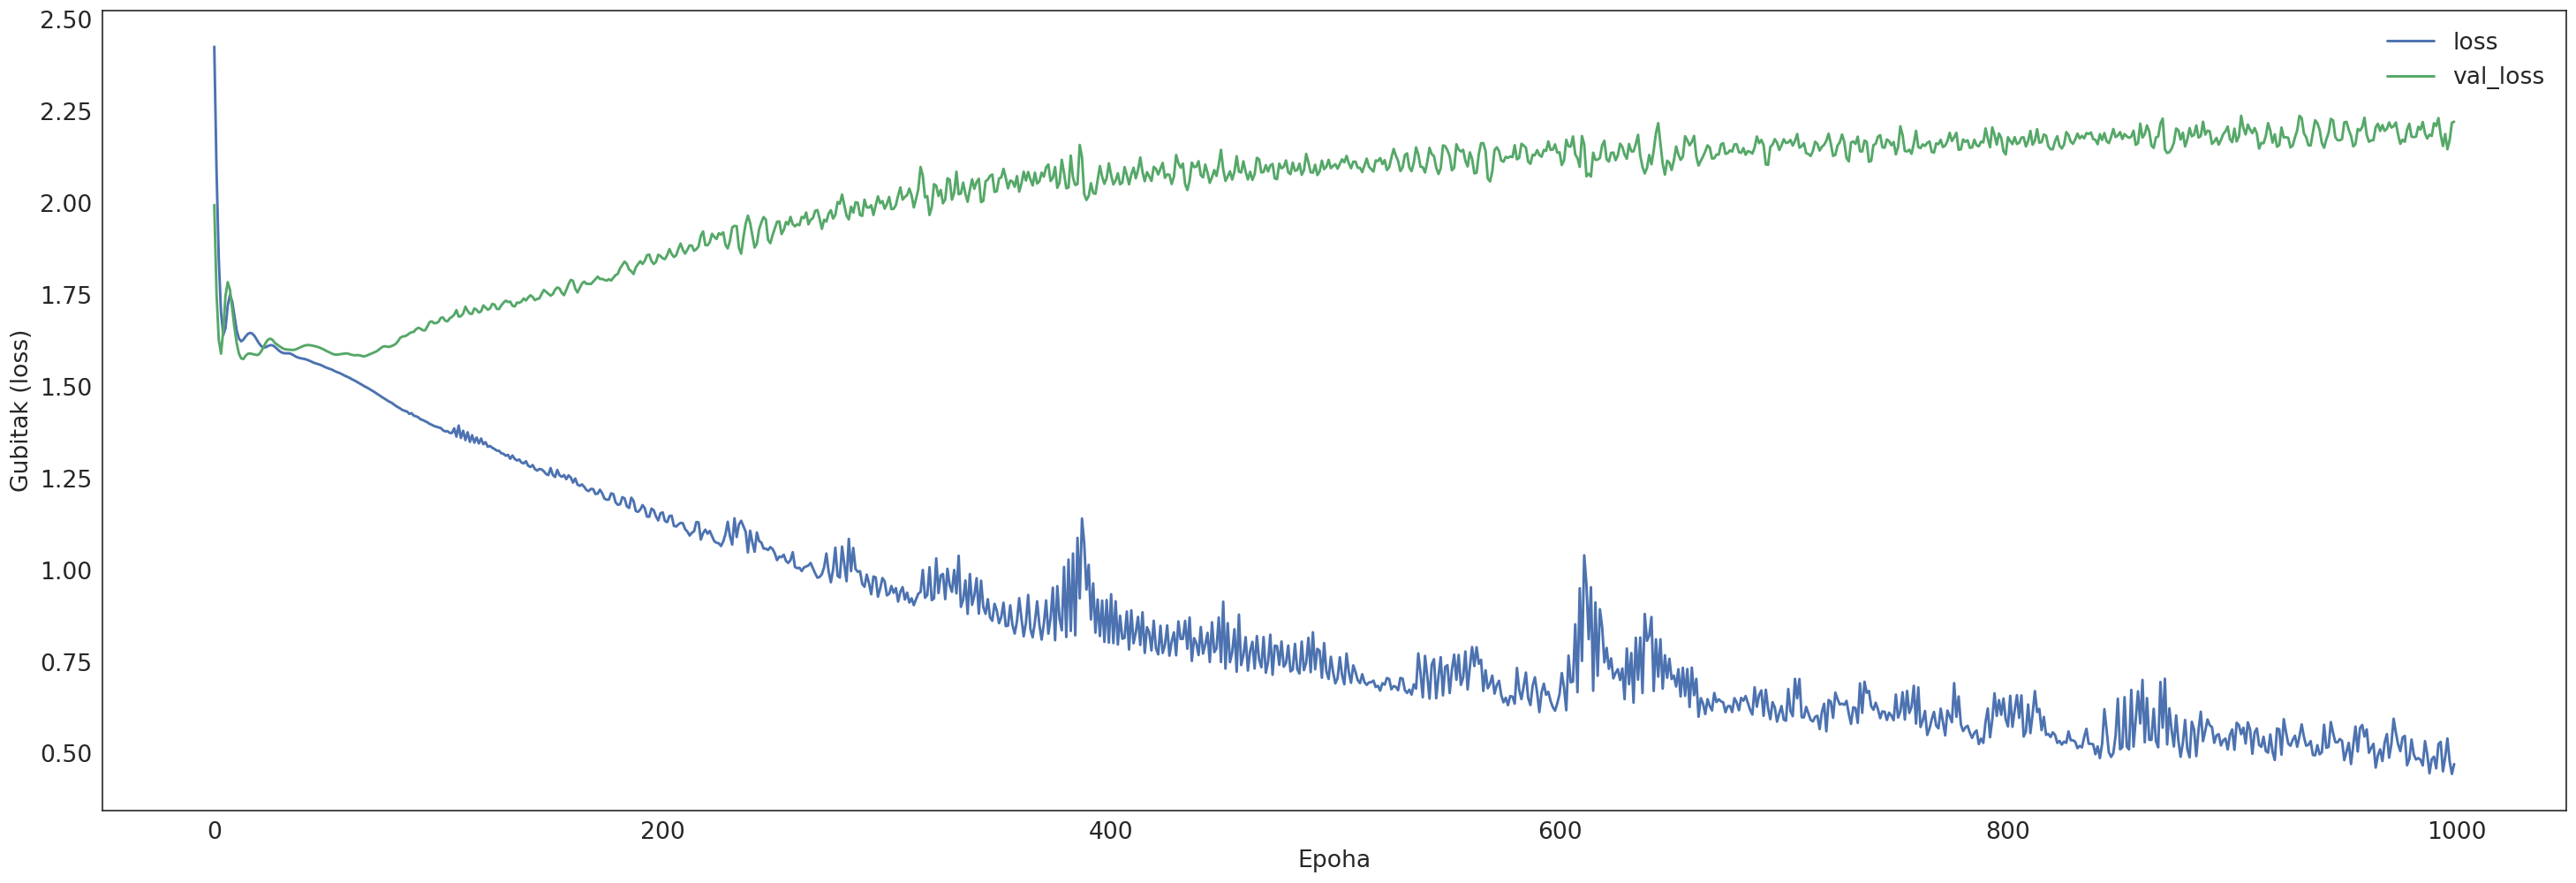

In [ ]:
import matplotlib.ticker as plticker

fig, (ax1)  = plt.subplots(1,1,figsize=(30,10), dpi=120)

loss = pd.DataFrame(model_9.history.history['loss'])
val_loss = pd.DataFrame(model_9.history.history['val_loss'])

# loc = plticker.MultipleLocator(base=5.0) # regularni intervali tikera
# ax1.xaxis.set_major_locator(loc)
ax1.plot(loss, label="loss")
ax1.plot(val_loss, label="val_loss")

ax1.legend(['loss', 'val_loss'])

ax1.set_xlabel("Epoha")
ax1.set_ylabel("Gubitak (loss)")

In [ ]:
INTO_FUTURE = len(test) 

In [ ]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

In [ ]:
# Zadnji datum
last_timestep = train.index[-1]


In [ ]:
# Kreiranje liste datuma za INTO_FUTURE dana/meseci
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE, period="M")


In [ ]:
volatility_monthly = pd.DataFrame(volatility_monthly)

In [ ]:
# Insertovanje datuma i vrednosti zbog grafika
next_time_steps_s = np.insert(next_time_steps, 0, last_timestep)
future_forecast_s = np.insert(future_forecast, 0, volatility_monthly.Close[-1])


In [ ]:
len(next_time_steps_s), len(future_forecast_s)

(89, 89)

In [ ]:
next_time_steps

array(['2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10',
       '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04',
       '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10',
       '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
       '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10',
       '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04',
       '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10',
       '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04',
       '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10',
       '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04',
       '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10',
       '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04',
       '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10',
       '2021-11', '2021-12', '2022-01', '2022-02', 

(array([732312., 733042., 733773., 734503., 735234., 735964., 736695.,
        737425., 738156., 738886.]),
 <a list of 10 Text major ticklabel objects>)

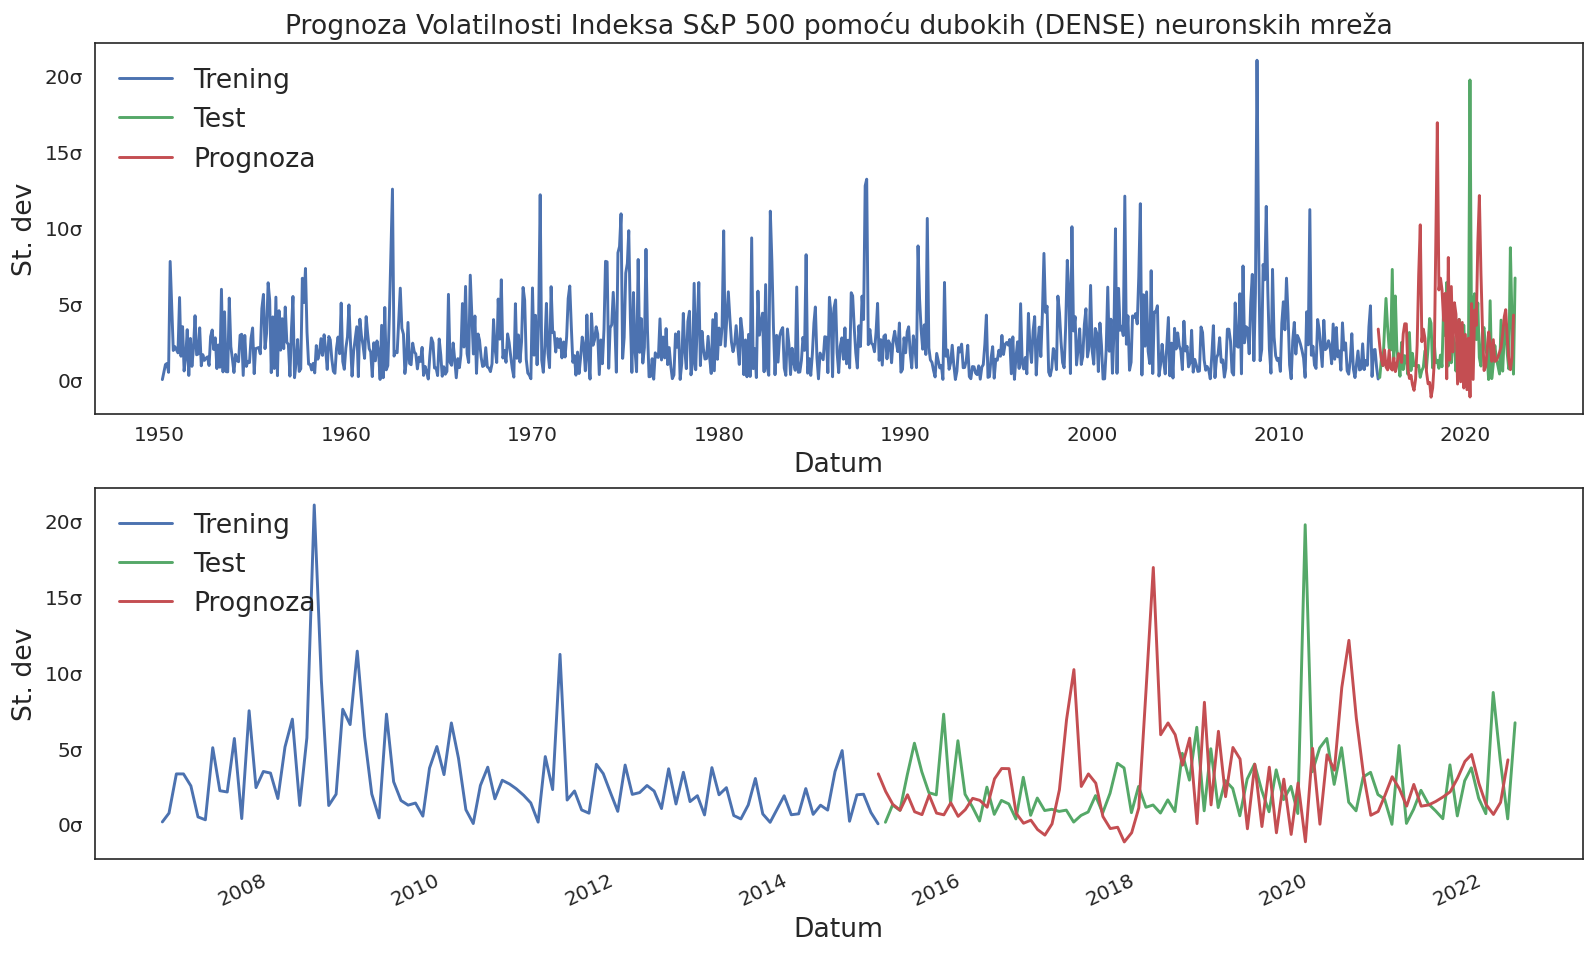

In [ ]:
# Plotovanje buducih cena
fig, (ax1, ax2)  = plt.subplots(2,1,figsize=(16,9), dpi=120)
plt.subplots_adjust(hspace=0.2)

ax1.plot(train.index, train.Close, label="Trening")
ax1.plot(test.index, test.Close, label="Test")
ax1.plot(next_time_steps, future_forecast, label="Predikcija")
ax1.legend(["Trening","Test", "Prognoza"])

ax2.plot(train.index[-100:], train.Close[-100:])
ax2.plot(test.index, test.Close)
ax2.plot(next_time_steps, future_forecast)

ax2.legend(["Trening","Test", "Prognoza"], loc="upper left")


ax1.set_title("Prognoza Volatilnosti Indeksa S&P 500 pomoću dubokih (DENSE) neuronskih mreža")
ax1.set_xlabel("Datum")
ax1.set_ylabel("St. dev")

ax2.set_xlabel("Datum")
ax2.set_ylabel("St. dev")

ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
fmt = '{x:,.0f}σ'

tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax2.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)

In [ ]:
getScores(test['Close'], future_forecast)

MSE: 16.33
MAE: 2.64
RMSE: 4.04
MAPE: 8.94
Corr: -0.0216
R_squared: 0.05%


In [ ]:
test

88

**Prognoza uz pomoc NN**

In [ ]:
HORIZON = 1
WINDOW_SIZE = 5
sp500_volatility_windowed_train = volatility_monthly.copy()

train = sp500_volatility_windowed_train

for i in range(WINDOW_SIZE):
  train[f"Volatility+{i+1}"] = volatility_monthly["Close"].shift(periods=i+1)

In [ ]:
volatility_monthly = pd.DataFrame(volatility_monthly)

In [ ]:
X_all = train.drop(["Close"], axis=1).dropna().to_numpy() 
y_all = train.dropna()["Close"].to_numpy()

In [ ]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

BATCH_SIZE = 1024 
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
tf.random.set_seed(42)

model_forecast = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

model_forecast.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

model_forecast.fit(dataset_all,
            epochs=1000,
            verbose=1) 

In [ ]:
INTO_FUTURE = 7

In [ ]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_forecast,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Okvir: 
 [0.7035002  8.68580873 4.18937312 0.36108697 6.69135131] -> Predkcija: 4.193014144897461

Okvir: 
 [8.68580873 4.18937312 0.36108697 6.69135131 4.19301414] -> Predkcija: 0.46530744433403015

Okvir: 
 [4.18937312 0.36108697 6.69135131 4.19301414 0.46530744] -> Predkcija: 1.1777135133743286

Okvir: 
 [0.36108697 6.69135131 4.19301414 0.46530744 1.17771351] -> Predkcija: 2.6154143810272217

Okvir: 
 [6.69135131 4.19301414 0.46530744 1.17771351 2.61541438] -> Predkcija: 5.995214939117432

Okvir: 
 [4.19301414 0.46530744 1.17771351 2.61541438 5.99521494] -> Predkcija: 1.6994850635528564

Okvir: 
 [0.46530744 1.17771351 2.61541438 5.99521494 1.69948506] -> Predkcija: 3.4528331756591797



In [ ]:
last_timestep = train.index[-1]
last_timestep

Timestamp('2022-08-31 00:00:00', freq='M')

In [ ]:
next_time_steps = get_future_dates(start_date=last_timestep,into_future=INTO_FUTURE, period="М")

TypeError: ignored

In [ ]:
next_time_steps_s = next_time_steps
future_forecast_s = np.insert(future_forecast[1:], 0, train.Close[-1])
next_time_steps_s

array(['2022-09-01', '2022-09-02', '2022-09-03', '2022-09-04',
       '2022-09-05', '2022-09-06', '2022-09-07'], dtype='datetime64[D]')

In [ ]:
len(next_time_steps), len(future_forecast_s)

(7, 7)

(array([734869., 735234., 735599., 735964., 736330., 736695., 737060.,
        737425., 737791., 738156., 738521.]),
 <a list of 11 Text major ticklabel objects>)

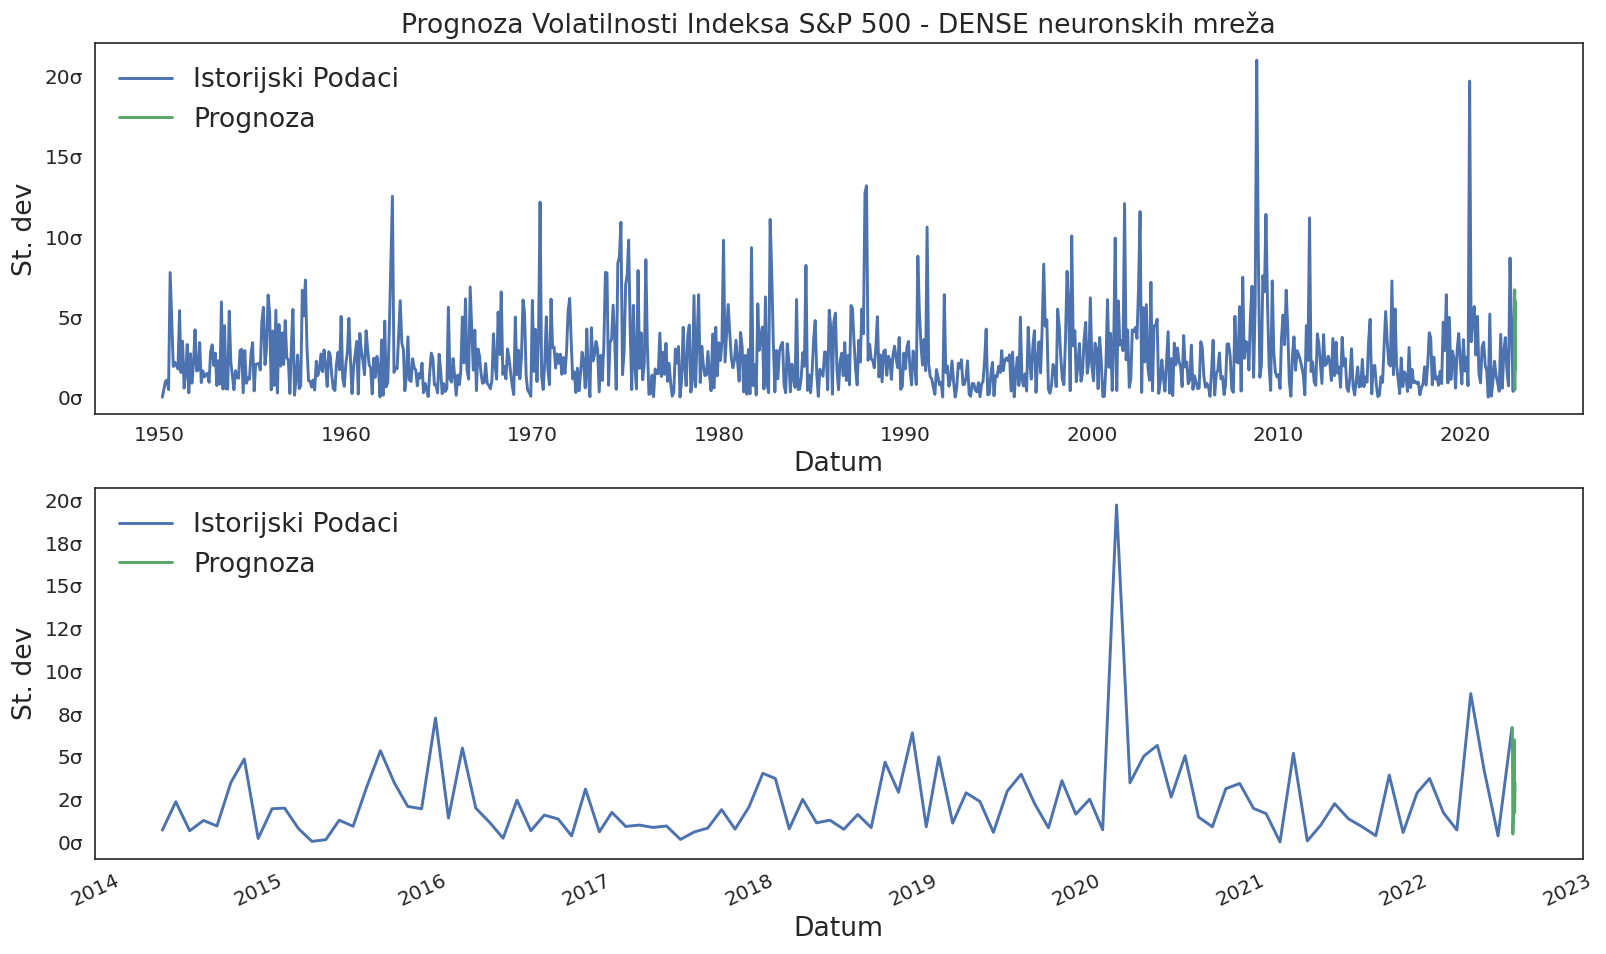

In [ ]:
fig, (ax1, ax2)  = plt.subplots(2,1,figsize=(16,9), dpi=120)
plt.subplots_adjust(hspace=0.2)

ax1.plot(train.index, train.Close, label="Trening")
ax1.plot(next_time_steps, future_forecast_s, label="Predikcija")



ax1.legend(["Istorijski Podaci", "Prognoza"])
ax1.set_title("Prognoza Volatilnosti Indeksa S&P 500 - DENSE neuronskih mreža")
ax1.set_xlabel("Datum")
ax1.set_ylabel("St. dev")

ax2.plot(train.index[-100:], train.Close[-100:])
ax2.plot(next_time_steps, future_forecast_s)
ax2.set_xlabel("Datum")
ax2.set_ylabel("St. dev")
ax2.legend(["Istorijski Podaci", "Prognoza"], loc='upper left')

ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
fmt = '{x:,.0f}σ'

tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax2.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)

In [ ]:
ret

Date
1950-01-04    1.140459
1950-01-05    0.474777
1950-01-06    0.295329
1950-01-09    0.588930
1950-01-10   -0.292736
                ...   
2022-08-15    0.396954
2022-08-16    0.187568
2022-08-17   -0.723779
2022-08-18    0.226956
2022-08-19   -1.290000
Name: Close, Length: 18276, dtype: float64